# Analysing raw PPG signals from EmbracePlus device

Adapted and Modified from: https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/4_smartring_data/Analysing_Smart_Ring_Data.ipynb to work for our EmbracePlus devices

In [1]:
#First let's import
import heartpy as hp
import matplotlib.pyplot as plt
from datetime import datetime

EmbracePlus devices exports raw data as a .avro data file. First, we need to convert the .avro to .csv files before analysing the raw PPG signals. Use the avroToCSV.py helper file for this. <br>
Note: PPG signals are recorded at 64Hz and timer units is given in UNIX timestamps (in microseconds). Calculate the sample rate anyways to make sure it is good.

In [2]:
# Load sample file
bvp_data = hp.get_data('bvp.csv', column_name = 'bvp')
timer_data = hp.get_data('bvp.csv', column_name='unix_timestamp')

# Datetime requires timestamp in seconds
# Convert unix_timestamp from microseconds to seconds
timer_data = timer_data/1000000

# Convert each timestamp to a formatted datetime object
datetime_data = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S.%f') for ts in timer_data]

# Calculate sample rate
sample_rate = int(hp.get_samplerate_datetime(datetime_data, timeformat='%Y-%m-%d %H:%M:%S.%f'))
print('sample rate is: %f Hz' %sample_rate)

sample rate is: 64.000000 Hz


### Plot the entire PPG signal recording

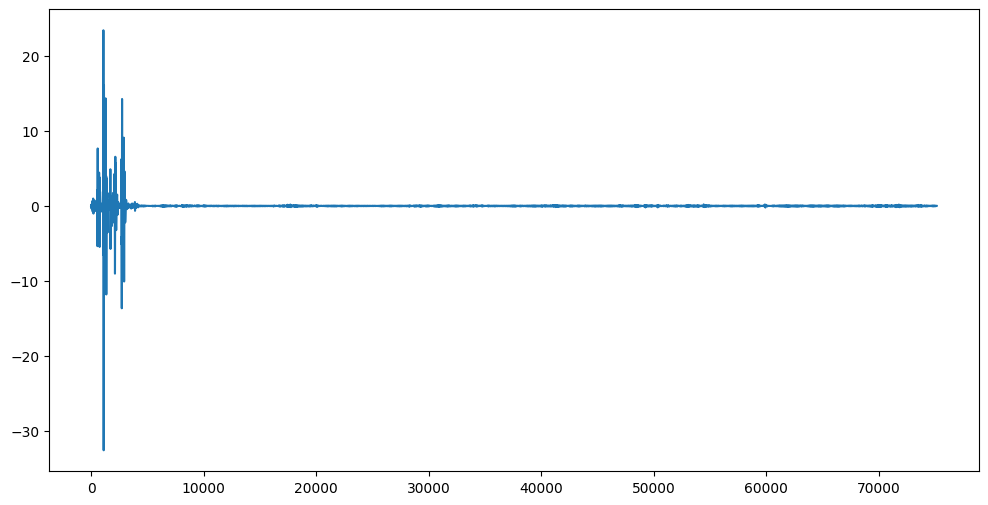

In [3]:
#plot data
plt.figure(figsize=(12,6))
plt.plot(bvp_data)
plt.show() 


Notice there is massive spikes at the beginning. These indicate that this portion of the recording may not have much of a PPG signal going on, but rather an interference or the user not actually wearing the device. <br> 
### Let's look at where we think we know there is a PPG signal going on.

#### 5 to 10 minutes in the recording:

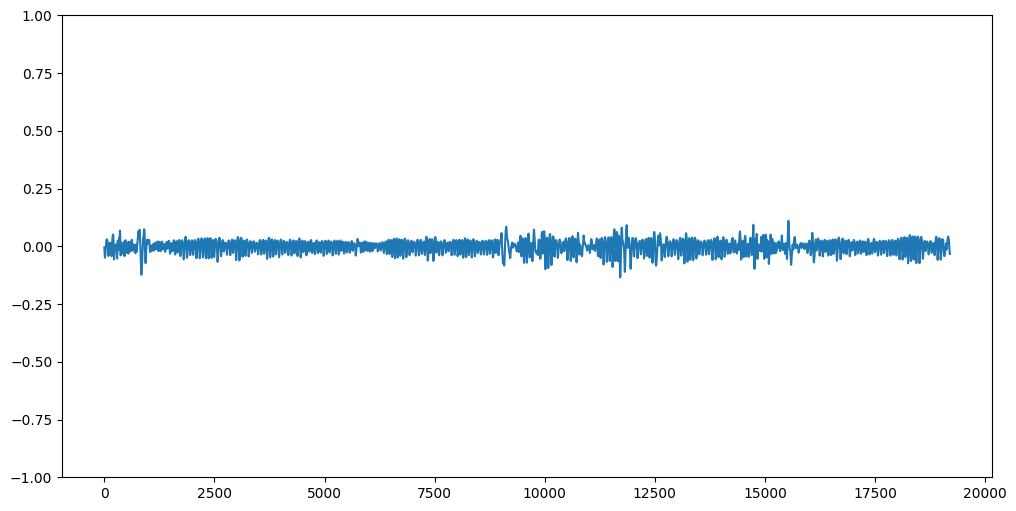

In [4]:
#plot first between 5 and 10 minute and zoomed in
plt.figure(figsize=(12,6))
plt.plot(bvp_data[(5 * 60) * sample_rate:(10 * 60) * sample_rate])
plt.ylim(-1, 1)
plt.show()

#### 5 to 6 minutes in the recording:

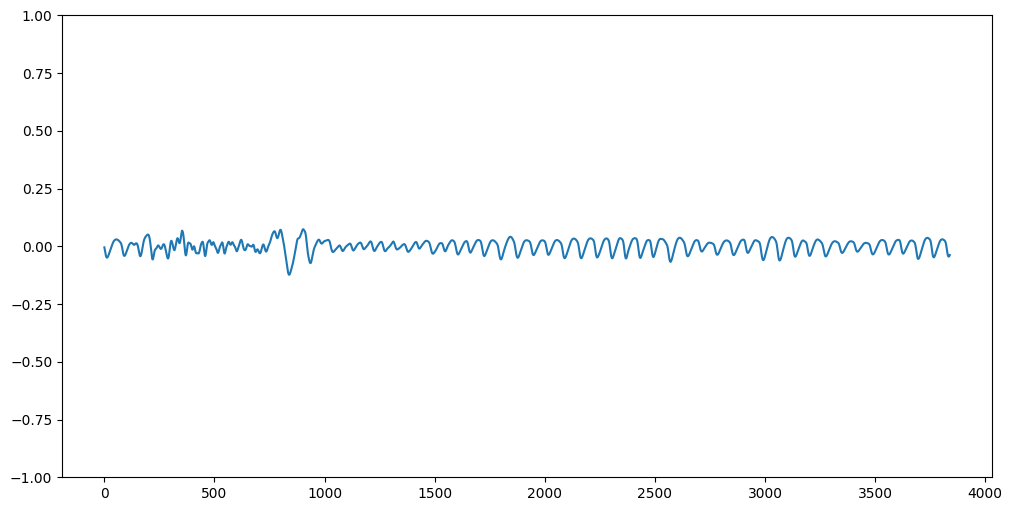

In [5]:
#plot first between 5 and 6 minute and zoomed in
plt.figure(figsize=(12,6))
plt.plot(bvp_data[(5 * 60) * sample_rate:(6 * 60) * sample_rate])
plt.ylim(-1, 1)
plt.show()

There's surely a signal going on here. However it does still have some strange peaks so we can filter out any outliers prior doing heart rate analysis.
### Filter using built-in heartpy filter implementations

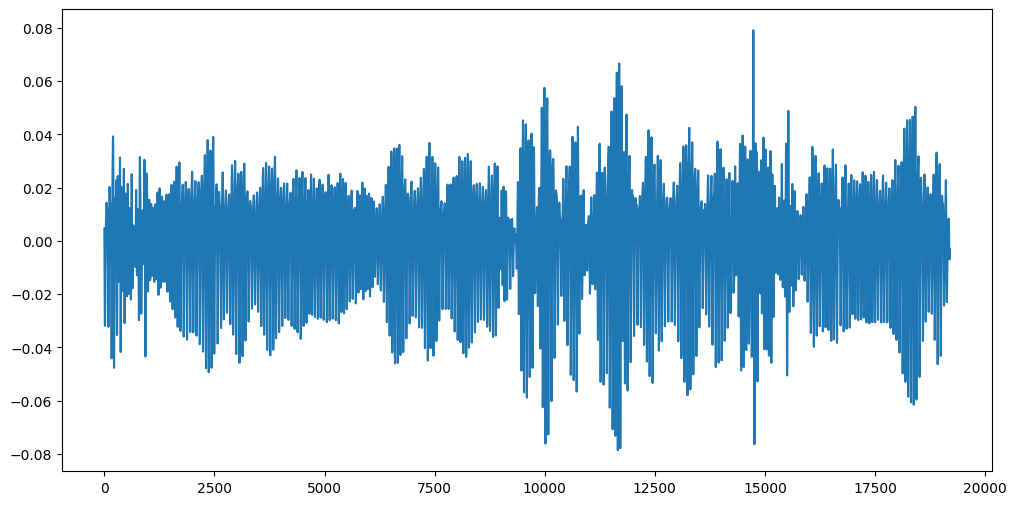

In [6]:
# Filter. We will use the bandpass variant.
# we filter out frequencies below 0.8Hz (<= 48 bpm)
# and above 3Hz (>= 180 bpm).
filtered_ppg = hp.filter_signal(bvp_data[(5 * 60) * sample_rate:
                                     (10 * 60) * sample_rate], 
                                cutoff = [0.8, 2.5], 
                                filtertype = 'bandpass',
                                sample_rate = sample_rate, 
                                order = 3,
                                return_top = False)

#plot the same segment as under 'zoomed in!' above
plt.figure(figsize=(12,6))
plt.plot(filtered_ppg)
plt.show()

### Now process and calculate heart rate signals


#### Not filtered prior analysis:

bpm: 58.551330
ibi: 1024.741875
sdnn: 129.389806
sdsd: 94.203656
rmssd: 165.192001
pnn20: 0.909605
pnn50: 0.790960
hr_mad: 96.562500
sd1: 116.807533
sd2: 132.943063
s: 48785.010510
sd1/sd2: 0.878628
breathingrate: 0.266667


<Figure size 2400x1200 with 0 Axes>

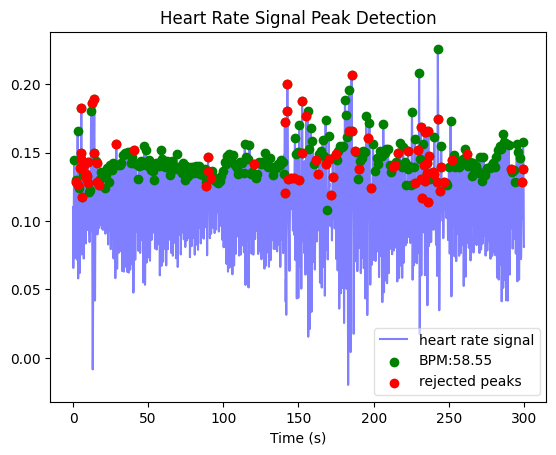

In [12]:
wd, m = hp.process(bvp_data[(5 * 60) * sample_rate:(10 * 60) * sample_rate], sample_rate=sample_rate,
                   high_precision = True)
plt.figure(figsize=(12,6))
hp.plotter(wd, m)

for key in m.keys():
    print('%s: %f' %(key, m[key]))

#### Filtered prior analysis:

bpm: 60.983920
ibi: 983.865919
sdnn: 111.624146
sdsd: 61.690754
rmssd: 89.603115
pnn20: 0.750000
pnn50: 0.461538
hr_mad: 66.812500
sd1: 62.939227
sd2: 144.554871
s: 28582.749650
sd1/sd2: 0.435400
breathingrate: 0.200000


<Figure size 1200x600 with 0 Axes>

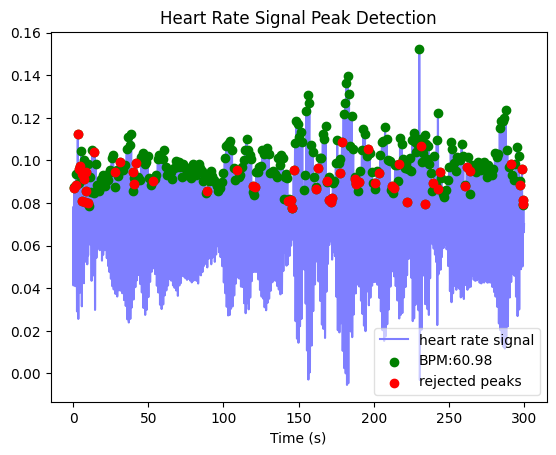

In [8]:
wd, m = hp.process(filtered_ppg, sample_rate=sample_rate,
                   high_precision = True)
plt.figure(figsize=(12,6))
hp.plotter(wd, m)

for key in m.keys():
    print('%s: %f' %(key, m[key]))

Notice how the unfiltered signal has much more rejected peaks (outliers). These may result in incorrect values of HRV metrics like RMSSD which are sensitive to outliers. This is the importance of filtering the signal prior analysis.

### Now notice how the signal is still quite noisy at the beginning.
HeartPy comes with an option to clean the peak-peak intervals prior to analysis. It will attempt to identify and reject outliers. If there's many 'good' peak-peak intervals to relatively few 'bad' ones, outlier detection works better.

bpm: 60.920731
ibi: 984.886416
sdnn: 107.861524
sdsd: 42.932493
rmssd: 67.216543
pnn20: 0.719780
pnn50: 0.417582
hr_mad: 63.875000
sd1: 47.442326
sd2: 139.093273
s: 20731.082036
sd1/sd2: 0.341083
breathingrate: 0.133333


C:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\heartpy\visualizeutils.py:299: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 1200x600 with 0 Axes>

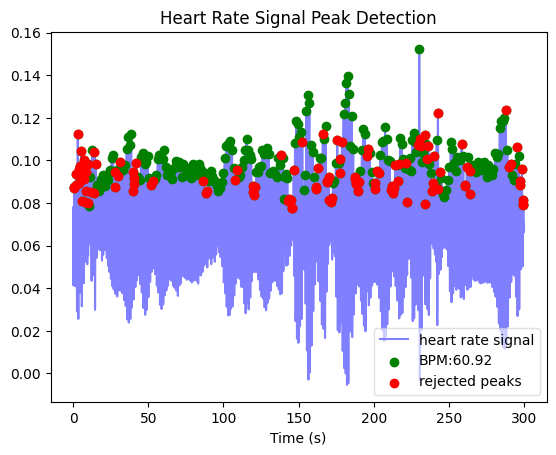

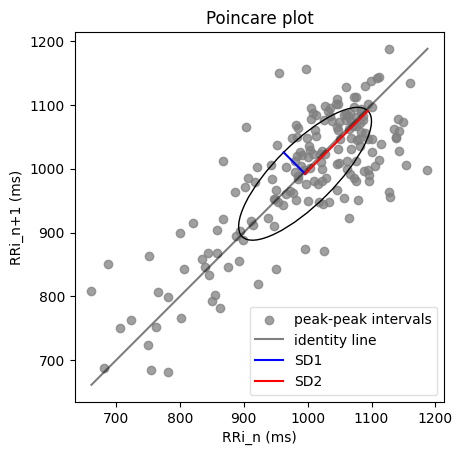

In [9]:
wd, m = hp.process(filtered_ppg, sample_rate=sample_rate,
                   high_precision = True, clean_rr = True)

plt.figure(figsize=(12,6))
hp.plotter(wd, m)

for key in m.keys():
    print('%s: %f' %(key, m[key]))
    
#and plot poincare
hp.plot_poincare(wd, m)

All HRV measures have fallen within acceptable ranges, suggesting that we have identified a few outliers, likely in the first minute segment (5 to 6 minutes in the whole recording)